In [19]:
import face_recognition
import numpy as np
import cv2
from PIL import Image,ImageDraw
import matplotlib.pyplot as plt
from compare_faces import compare_faces_all_stats_and_metrics, compare_faces
from pathlib import Path
from typing import Any
import pandas as pd
from functools import partial

In [20]:
def align_face(image):
    landmarks = face_recognition.face_landmarks(image)
    if not landmarks:
        raise ValueError("Face landmarks not found.")
    
    points = landmarks[0]
    left_eye = np.mean(points['left_eye'], axis=0)
    right_eye = np.mean(points['right_eye'], axis=0)

    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dy, dx))

    eyes_center = ((left_eye[0] + right_eye[0]) / 2,
                   (left_eye[1] + right_eye[1]) / 2)

    M = cv2.getRotationMatrix2D(eyes_center, angle, 1)

    aligned = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]),
                     flags=cv2.INTER_CUBIC)
    return aligned

In [21]:
def extract_aligned_face(image: np.ndarray, target_size=(224, 224)) -> np.ndarray:
    """
    Detects, aligns, crops, and resizes the face in the image.
    
    Parameters:
        image (np.ndarray): RGB or BGR image.
        target_size (tuple): Desired output size (width, height).
    
    Returns:
        np.ndarray: Aligned and cropped face image.
    """
    if image.shape[2] == 3 and np.max(image) > 1:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image_rgb = image.copy()

    aligned = align_face(image_rgb)

    boxes = face_recognition.face_locations(aligned)
    if not boxes:
        raise ValueError("No face detected after alignment.")
    
    top, right, bottom, left = boxes[0]

    cropped_face = aligned[top:bottom, left:right]

    resized_face = cv2.resize(cropped_face, target_size, interpolation=cv2.INTER_AREA)

    return resized_face

In [22]:
def load_images_and_names(
    folder,
    valid_ext = {".jpg", ".jpeg", ".png", ".jfif", ".bmp", ".tiff"},
    to_rgb: bool = True,
    normalize: bool = False
):
    """
    Зчитує всі зображення з папки і повертає два паралельні списки:
      - images: List[np.ndarray]  — масиви зображень
      - names:  List[str]        — імена файлів без розширень

    Параметри
    ---------
    folder : str або Path
        Шлях до папки з зображеннями.
    valid_ext : set[str]
        Дозволені розширення файлів (включно з крапкою).
    to_rgb : bool
        Чи конвертувати BGR→RGB (якщо використовуєте OpenCV).
    normalize : bool
        Чи масштабувати пікселі у [0,1] (float32).

    Повертає
    -------
    images, names
    """
    folder = Path(folder)
    image_paths = sorted(
        [p for p in folder.iterdir() if p.suffix.lower() in valid_ext]
    )

    images = []
    names  = []

    for p in image_paths:
        img = cv2.imread(str(p), cv2.IMREAD_COLOR)
        if img is None:
            print(f"[WARN] Не вдалося відкрити {p.name}")
            continue

        if to_rgb:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if normalize:
            img = img.astype(np.float32) / 255.0

        images.append(img)
        names.append(p.stem)

    return images, names

In [23]:
images1, names1 = load_images_and_names("data/faces_1")
images2, names2 = load_images_and_names("data/faces_2")

compare_faces_all_stats_and_metrics(images1[0],images2[0])

{'mean': {'euclidean': 2.363, 'manhattan': 2.3938},
 'std': {'euclidean': 0.2531, 'manhattan': 0.4949},
 'var': {'euclidean': 0.7784, 'manhattan': 0.911},
 'entropy': {'euclidean': 0.7523, 'manhattan': 1.389}}

In [24]:
def create_pairwise_comparison_df(names1,images1,names2,images2,wavelet):
    rows = []
    for name1, img1 in zip(names1, images1):
        for name2, img2 in zip(names2, images2):
            stats = compare_faces_all_stats_and_metrics(img1, img2,wavelet)
            row = {
                "name1": name1,
                "name2": name2,
            }
            for stat, metric_vals in stats.items():
                for metric, value in metric_vals.items():
                    col = f"{stat}_{metric}"
                    row[col] = value
            rows.append(row)

    df = pd.DataFrame(rows)
    return df

df_db_before = create_pairwise_comparison_df(names1,images1,names2,images2,"db4")
df_db_before

,name1,name2,mean_euclidean,mean_manhattan,std_euclidean,std_manhattan,var_euclidean,var_manhattan,entropy_euclidean,entropy_manhattan
0,biden1,biden2,2.3630,2.3938,0.2531,0.4949,0.7784,0.9110,0.7523,1.3890
1,biden1,deniro2,2.3644,2.3759,0.4029,0.6493,1.5291,1.6279,0.9849,1.8949
2,biden1,dicaprio2,3.5137,3.5347,1.3450,1.5634,4.0625,4.1166,0.4001,0.7463
3,biden1,downey2,1.2038,1.2171,0.1671,0.3696,0.5282,0.6132,1.3600,2.4996
4,biden1,johny_depp2,3.0895,3.1038,0.6167,0.8296,2.2824,2.3433,15.2370,47.9602
5,biden1,Maksym2,1.9236,1.9378,0.4423,0.8937,1.5366,1.6390,10.7425,32.7388
6,biden1,swift2,0.9814,0.9976,0.2845,0.4357,1.1409,1.1668,0.8583,1.4988
7,deniro1,biden2,0.0557,0.0776,0.7784,1.0118,2.4785,2.5817,0.1318,0.2787
8,deniro1,deniro2,0.0518,0.0608,0.5778,0.8338,1.7226,1.8034,0.1120,0.2728
9,deniro1,dicaprio2,1.0977,1.1103,0.4157,0.6665,0.8145,0.9016,0.4885,0.9893


In [25]:
extract = partial(extract_aligned_face, target_size=(224, 224))

aligned_images1 = list(map(extract, images1))
aligned_images2 = list(map(extract, images2))

df_db_after = create_pairwise_comparison_df(names1,aligned_images1,names2,aligned_images2,"db4")
df_db_after

,name1,name2,mean_euclidean,mean_manhattan,std_euclidean,std_manhattan,var_euclidean,var_manhattan,entropy_euclidean,entropy_manhattan
0,biden1,biden2,0.0069,0.0132,0.9419,1.0484,2.6536,2.6759,0.7789,1.3804
1,biden1,deniro2,1.6198,1.6355,0.1912,0.4536,0.4027,0.4923,0.8959,1.5814
2,biden1,dicaprio2,1.5843,1.5909,0.2557,0.3432,0.8869,0.9053,0.8984,1.5875
3,biden1,downey2,0.7728,0.7826,0.2218,0.3177,0.7704,0.7948,0.8966,1.5821
4,biden1,johny_depp2,1.3494,1.3660,0.2723,0.4879,0.8967,0.9394,0.9010,1.5898
5,biden1,Maksym2,2.0308,2.0381,0.1469,0.3185,0.4189,0.4653,0.9008,1.5900
6,biden1,swift2,1.8111,1.8281,0.4509,0.5949,1.4726,1.5112,0.9006,1.5897
7,deniro1,biden2,1.3903,1.4008,0.1515,0.2684,0.2851,0.3077,0.1220,0.2129
8,deniro1,deniro2,0.2258,0.2392,0.7142,1.0956,1.9715,2.0866,0.0050,0.0085
9,deniro1,dicaprio2,0.1902,0.1968,0.5500,0.6740,1.4819,1.5064,0.0030,0.0059


In [26]:
df_haar_before = create_pairwise_comparison_df(names1,images1,names2,images2,"haar")
df_haar_before

,name1,name2,mean_euclidean,mean_manhattan,std_euclidean,std_manhattan,var_euclidean,var_manhattan,entropy_euclidean,entropy_manhattan
0,biden1,biden2,1.8699,1.9491,0.2683,0.4955,0.8005,0.9734,1.6436,4.3310
1,biden1,deniro2,1.7705,1.8105,0.4038,0.5939,1.5715,1.6671,6.6470,19.6447
2,biden1,dicaprio2,3.1261,3.1718,1.3066,1.6202,4.0226,4.1371,3.8085,11.7191
3,biden1,downey2,0.6713,0.7454,0.2004,0.3603,0.7859,0.8590,6.7587,20.7843
4,biden1,johny_depp2,2.7540,2.8055,0.6683,1.1041,2.3787,2.5400,8.4650,22.2805
5,biden1,Maksym2,1.6496,1.6946,0.4978,1.1290,1.5524,1.7558,2.8753,7.5914
6,biden1,swift2,0.9964,1.0567,0.3671,0.5481,1.4549,1.4943,4.0956,11.7894
7,deniro1,biden2,0.0944,0.1465,0.7783,1.1988,2.4419,2.6808,1.5352,4.2385
8,deniro1,deniro2,0.1853,0.2020,0.5662,0.9276,1.6550,1.8097,4.1844,11.6040
9,deniro1,dicaprio2,1.1707,1.1858,0.3892,0.5995,0.8014,0.8818,6.4372,19.7597


In [27]:
df_haar_after = create_pairwise_comparison_df(names1,aligned_images1,names2,aligned_images2,"haar")
df_haar_after

,name1,name2,mean_euclidean,mean_manhattan,std_euclidean,std_manhattan,var_euclidean,var_manhattan,entropy_euclidean,entropy_manhattan
0,biden1,biden2,0.2966,0.3871,0.8741,1.1083,2.0887,2.1692,4.0275,8.4524
1,biden1,deniro2,1.1790,1.2556,0.1583,0.4070,0.1835,0.2951,5.6585,14.7923
2,biden1,dicaprio2,1.0558,1.1413,0.2159,0.2743,0.6572,0.6739,2.5602,7.0717
3,biden1,downey2,0.1545,0.2356,0.3287,0.4130,0.9629,0.9897,1.7541,4.8905
4,biden1,johny_depp2,0.8874,0.9613,0.1679,0.3228,0.4865,0.5250,5.6490,14.0856
5,biden1,Maksym2,1.5326,1.6365,0.1540,0.3324,0.3476,0.4208,5.1738,13.0986
6,biden1,swift2,1.4274,1.5075,0.2924,0.4132,0.8467,0.8928,2.7995,7.8783
7,deniro1,biden2,1.3725,1.4054,0.1864,0.2660,0.3156,0.3360,5.5424,12.1611
8,deniro1,deniro2,0.0963,0.1077,0.6747,1.1852,1.6074,1.8040,3.8040,8.6573
9,deniro1,dicaprio2,0.0277,0.0361,0.4870,0.6627,1.1174,1.1921,3.2925,6.2009


In [28]:
df_bior_before = create_pairwise_comparison_df(names1,images1,names2,images2,"bior4.4")
df_bior_before

,name1,name2,mean_euclidean,mean_manhattan,std_euclidean,std_manhattan,var_euclidean,var_manhattan,entropy_euclidean,entropy_manhattan
0,biden1,biden2,2.3036,2.3303,0.3238,0.5921,1.1727,1.2948,0.9056,1.7560
1,biden1,deniro2,2.2599,2.2904,0.3905,0.5783,1.5717,1.6333,1.2159,2.2305
2,biden1,dicaprio2,3.4317,3.4479,1.4546,1.6205,4.4525,4.4878,0.3174,0.4342
3,biden1,downey2,0.9171,0.9479,0.2395,0.3954,0.9849,1.0314,1.6164,2.9606
4,biden1,johny_depp2,2.9472,2.9648,0.6850,0.8712,2.6020,2.6510,15.1476,47.6051
5,biden1,Maksym2,1.8014,1.8197,0.4959,0.9224,1.8474,1.9346,10.3640,31.2418
6,biden1,swift2,0.7304,0.7589,0.3832,0.5464,1.5657,1.5903,1.0553,1.8206
7,deniro1,biden2,0.0633,0.0766,0.7347,1.0169,2.3258,2.4485,0.1347,0.2557
8,deniro1,deniro2,0.1072,0.1262,0.6176,0.8482,1.9222,1.9867,0.2287,0.6477
9,deniro1,dicaprio2,1.0652,1.0870,0.4678,0.6138,0.9594,0.9944,0.8346,1.4828


In [29]:
df_bior_after = create_pairwise_comparison_df(names1,aligned_images1,names2,aligned_images2,"bior4.4")
df_bior_after

,name1,name2,mean_euclidean,mean_manhattan,std_euclidean,std_manhattan,var_euclidean,var_manhattan,entropy_euclidean,entropy_manhattan
0,biden1,biden2,0.1657,0.1938,0.9631,1.1040,2.8054,2.8387,0.9503,1.6908
1,biden1,deniro2,1.5713,1.5798,0.1957,0.4690,0.4359,0.5223,1.1170,1.9797
2,biden1,dicaprio2,1.5230,1.5349,0.3111,0.3699,1.1069,1.1177,1.1184,1.9818
3,biden1,downey2,0.5914,0.6031,0.3669,0.4640,1.2782,1.3028,1.1196,1.9824
4,biden1,johny_depp2,1.2228,1.2491,0.3017,0.5505,1.0135,1.0641,1.1244,1.9916
5,biden1,Maksym2,1.7700,1.7904,0.2062,0.3836,0.6820,0.7203,1.1238,1.9905
6,biden1,swift2,1.5210,1.5414,0.5334,0.6562,1.7753,1.8062,1.1237,1.9908
7,deniro1,biden2,1.4499,1.4714,0.1529,0.2366,0.3089,0.3236,0.1737,0.2975
8,deniro1,deniro2,0.2868,0.3057,0.7164,1.0762,2.0646,2.1629,0.0069,0.0107
9,deniro1,dicaprio2,0.2385,0.2570,0.5082,0.6475,1.3897,1.4213,0.0050,0.0085


In [ ]:
from scipy.stats import ttest_rel

def analyze_face_metrics_stats(df_before: pd.DataFrame, df_after: pd.DataFrame) -> pd.DataFrame:

    df_before = df_before.drop(columns=['Unnamed: 0'], errors='ignore')
    df_after = df_after.drop(columns=['Unnamed: 0'], errors='ignore')

    df_before = df_before.add_prefix("before_")
    df_after = df_after.add_prefix("after_")

    df_combined = pd.concat([df_before, df_after], axis=1)

    def base_name(name):
        return ''.join(filter(str.isalpha, str(name)))
    
    same_person = df_combined[
        df_combined['before_name1'].apply(base_name) == df_combined['before_name2'].apply(base_name)
    ]

    metrics = [
        "mean_euclidean", "mean_manhattan",
        "std_euclidean", "std_manhattan",
        "var_euclidean", "var_manhattan",
        "entropy_euclidean", "entropy_manhattan"
    ]

    results = []
    for metric in metrics:
        stat, pval = ttest_rel(
            same_person[f"before_{metric}"],
            same_person[f"after_{metric}"]
        )
        results.append({
            "Метрика": metric,
            "t-статистика": round(stat, 4),
            "p-значення": round(pval, 4)
        })

    results_df = pd.DataFrame(results)
    return results_df, same_person 

results,same_person = analyze_face_metrics_stats(df_db_before,df_db_after)
results
before_metrics = same_person.filter(like="after_")
before_metrics.to_csv("output.csv")

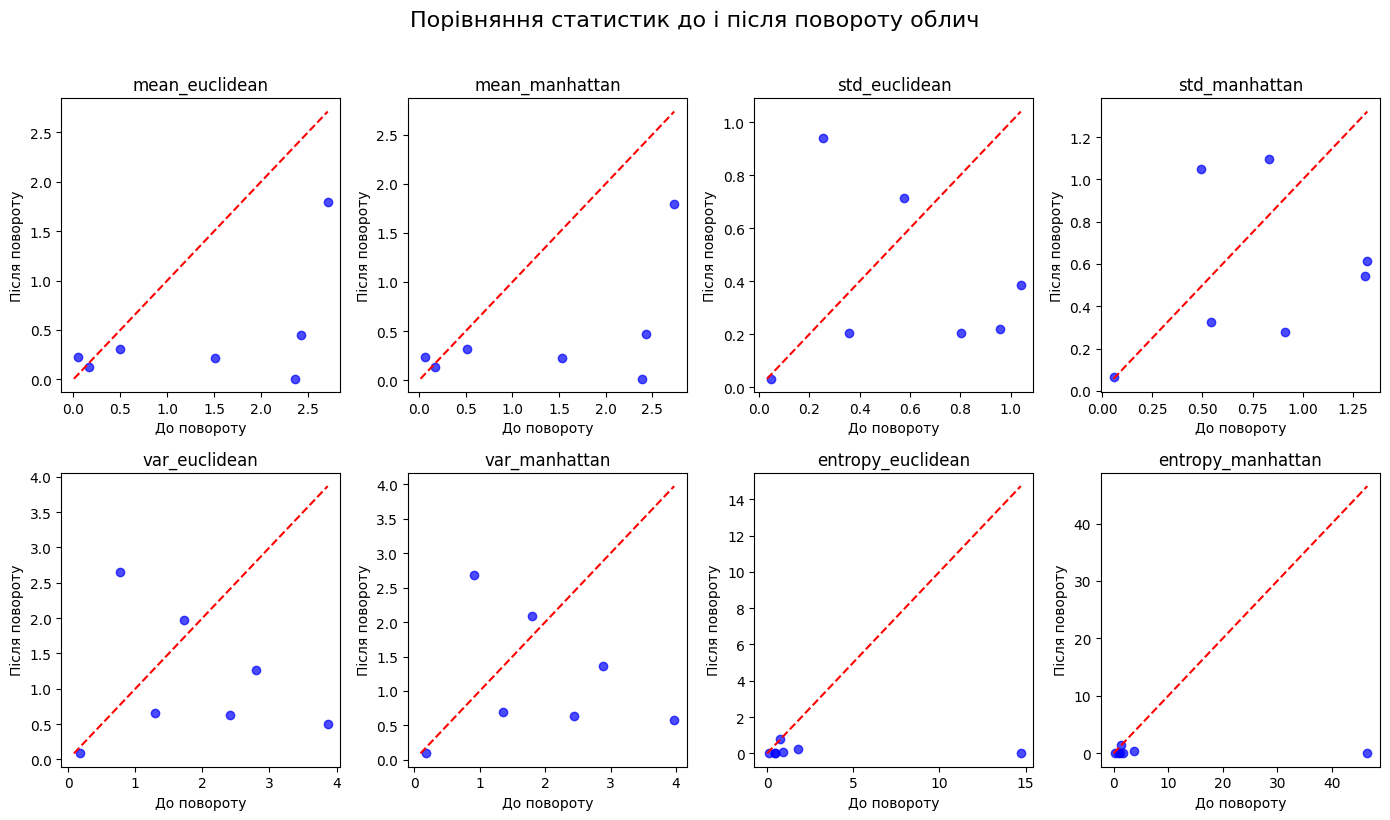

In [46]:
import matplotlib.pyplot as plt

def plot_face_metrics_comparison(same_person: pd.DataFrame):
    metrics = [
        "mean_euclidean", "mean_manhattan",
        "std_euclidean", "std_manhattan",
        "var_euclidean", "var_manhattan",
        "entropy_euclidean", "entropy_manhattan"
    ]

    plt.figure(figsize=(14, 8))
    for idx, metric in enumerate(metrics):
        plt.subplot(2, 4, idx + 1)
        plt.scatter(
            same_person[f'before_{metric}'],
            same_person[f'after_{metric}'],
            color='blue', alpha=0.7
        )
        min_val = min(same_person[f'before_{metric}'].min(), same_person[f'after_{metric}'].min())
        max_val = max(same_person[f'before_{metric}'].max(), same_person[f'after_{metric}'].max())
        plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

        plt.xlabel('До повороту')
        plt.ylabel('Після повороту')
        plt.title(metric)

    plt.suptitle('Порівняння статистик до і після повороту облич', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

plot_face_metrics_comparison(same_person)

In [41]:
results,same_person = analyze_face_metrics_stats(df_haar_before,df_haar_after)
results

,Метрика,t-статистика,p-значення
0,mean_euclidean,2.7102,0.0351
1,mean_manhattan,2.7098,0.0351
2,std_euclidean,0.6384,0.5468
3,std_manhattan,0.7909,0.4591
4,var_euclidean,1.0956,0.3153
5,var_manhattan,1.1585,0.2907
6,entropy_euclidean,0.1930,0.8533
7,entropy_manhattan,1.8257,0.1177


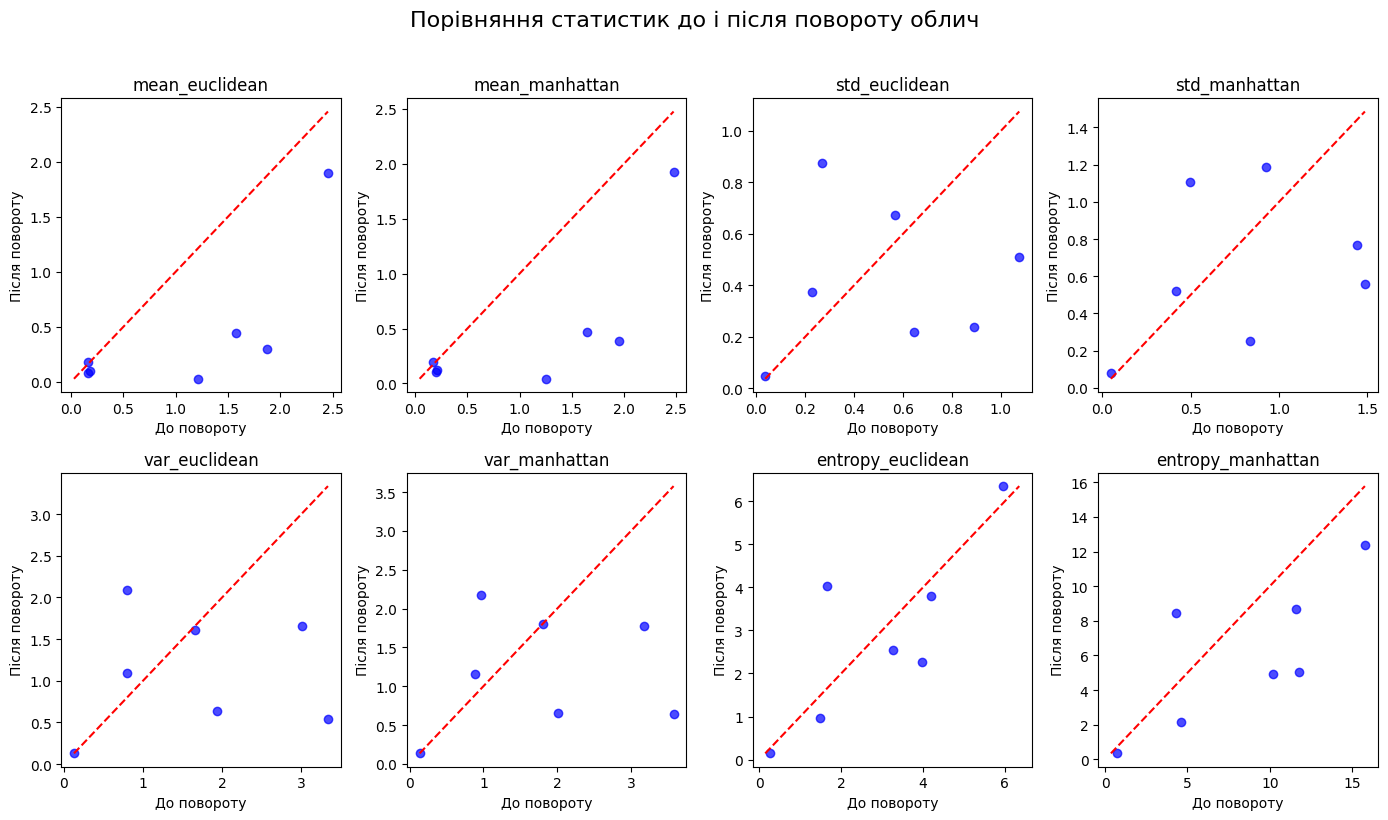

In [42]:
plot_face_metrics_comparison(same_person)

In [43]:
results,same_person = analyze_face_metrics_stats(df_bior_before,df_bior_after)
results

,Метрика,t-статистика,p-значення
0,mean_euclidean,2.5430,0.0439
1,mean_manhattan,2.5503,0.0435
2,std_euclidean,0.8925,0.4065
3,std_manhattan,0.9741,0.3676
4,var_euclidean,1.0988,0.3140
5,var_manhattan,1.1304,0.3015
6,entropy_euclidean,1.2794,0.2480
7,entropy_manhattan,1.2027,0.2744


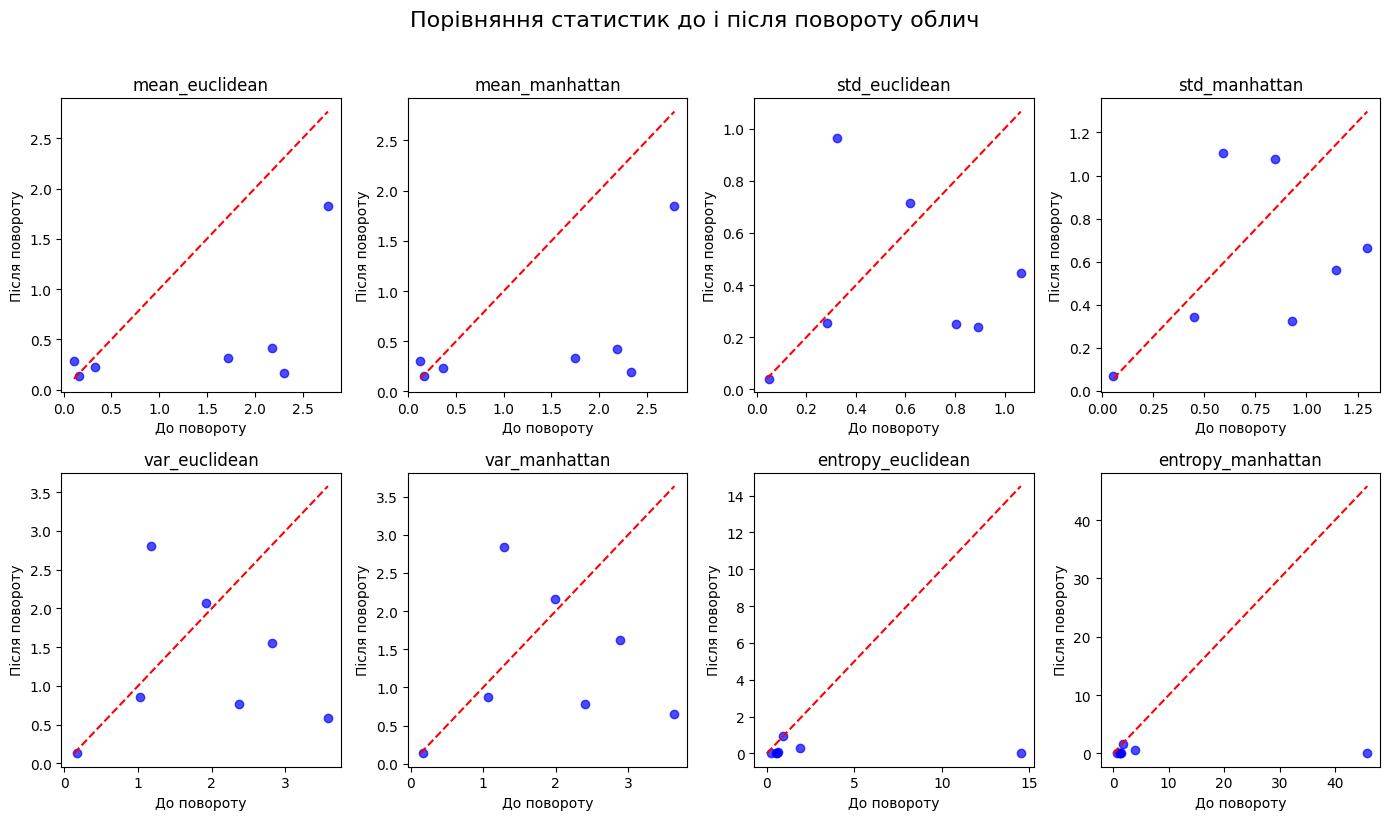

In [44]:
plot_face_metrics_comparison(same_person)